In [369]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
from sklearn import cross_validation,metrics
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
import json

loc_type = 'home'
version = 'v200'
input_filename = ".users.training.v2.%s" % loc_type
target_acc = {
    "nn_home":0.80,
    "nn_work":0.75,
    "rf_home":0.83,
    "rf_work":0.77,
}

print 'done'

done


In [378]:

# 

MIN_CLUSTER_POINT_COUNT = 13
MAX_POSITIVE_DATA = 4361
MAX_NEGATIVE_DATA = MAX_POSITIVE_DATA

def load_data():
    X_res = []
    y_res = []
    rows = []
    c1 = 0
    c0 = 0
    for line in open(input_filename):
        try:
            row = json.loads(line.strip())
        except:
            print 'failed to load json', line
        if row['point_count'] < MIN_CLUSTER_POINT_COUNT:
            continue
        label = row['label']
        if label == 0:
            if c0 > MAX_NEGATIVE_DATA:
                continue
            else:
                c0 += 1
        elif label == 1:
            if c1 > MAX_POSITIVE_DATA:
                continue
            else:
                c1 += 1
        X_res.append(row['features'])
        y_res.append(label)
    print 'raw label 0:1', c0, c1
    return np.array(X_res, dtype='float64'), np.array(y_res, dtype='int'), rows

X, y, rows = load_data()  # rows是原始输入数据，每个元素就是输入文件中的一行
print 'raw data', len(y), np.sum(y)


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print 'training & test dataset', X_train.shape, X_test.shape

print 'done'

raw label 0:1 4361 4362
raw data 8723 4362
training & test dataset (6978, 48) (1745, 48)
done


In [360]:
# 计算准召

def evaluate(result, y_test):
    wrong_count = np.sum(np.abs(result - y_test))
    total_count = len(y_test)
    acc = float(total_count - wrong_count) / total_count
    
    idx = y_test == 1
    result1 = result[idx]
    right_count = np.sum(result1)
    total_count = np.sum(y_test)
    recall = float(right_count) / total_count

    return acc, recall

# cache

def run(filename, callback, generate_new=False):
    if not generate_new and os.path.exists(filename):
        print 'cache hit:', filename
        return pickle.loads(open(filename).read())
    data = callback()
    with open(filename, 'w') as fout:
        fout.write(pickle.dumps(data))
    return data


def find_best(thresh_list, list1, list2, target_value):
    best_idx = -1
    for i in range(len(acc_list)):
        v1 = list1[i]
        if v1 > target_value:
            v2 = list2[i]
            if v2 > list2[best_idx]:
                best_idx = i
    if best_idx == -1:
        print 'best thresh not found'
        return
    print 'best thresh:', thresh_list[best_idx], 'acc:recall', list1[best_idx], list2[best_idx], 'target acc:', target_value

def judge(clf, proba, target_acc=0.75):
    auc = metrics.roc_auc_score(y_test, proba)
    print 'auc:', auc
    print 'acc on training data:', clf.score(X_train, y_train)
    print 'acc on test data:', clf.score(X_test, y_test)

    acc_list = []
    recall_list = []
    thresh_list = []
    auc_list = []

    for proba_thresh in np.linspace(0,1,100):
        result = np.array(proba>proba_thresh, dtype='int')
        acc, recall = evaluate(result, y_test)        
        # print proba_thresh, acc, recall
        acc_list.append(acc)
        recall_list.append(recall)
        thresh_list.append(proba_thresh)
        auc_list.append(auc)

    def plot(area, x_label, y_label, x, y):
        plt.subplot(area)
        plt.title('%s - %s' % (x_label, y_label))
        #plt.xlabel(x_label)
        #plt.ylabel(y_label)
        plt.plot(x, y)
        plt.plot([0,1],[0,1])
    
    find_best(thresh_list, acc_list, recall_list, target_acc)
    
    plot(331, 'thresh', 'accuracy', thresh_list, acc_list)
    plot(332, 'thresh', 'recall', thresh_list, recall_list)
    plot(333, 'recall', 'accuracy', recall_list, acc_list)

    FP_list, TP_list, thresh_list = metrics.roc_curve(y_test, proba, pos_label=1)
    plot(334, 'thresh', 'FP', thresh_list, FP_list)
    plot(335, 'thresh', 'TP', thresh_list, TP_list)
    plot(336, 'FP', 'TP', FP_list, TP_list)

    plt.show()
    # print 'score of train:test', clf.score(X_train, y_train), clf.score(X_test, y_test)


auc: 0.866960167715
acc on training data: 0.805334298817
acc on test data: 0.810068649886
best thresh: 0.414141414141 acc:recall 0.800915331808 0.86320754717 target acc: 0.8


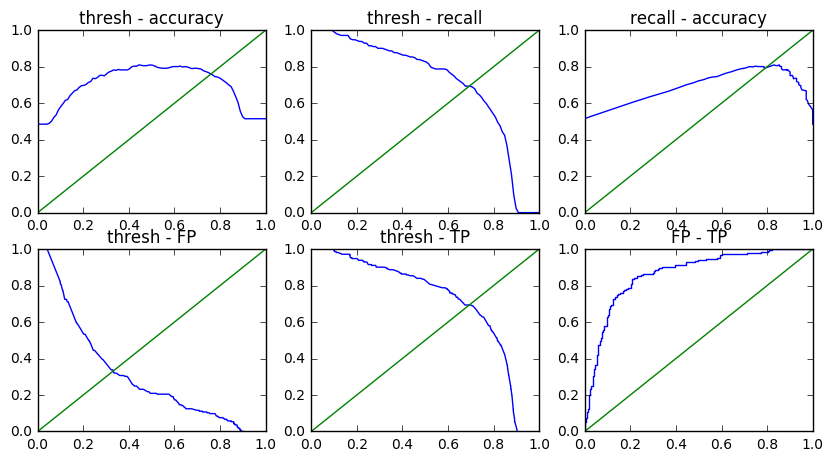

In [375]:
from sklearn import neural_network
import time, os, pickle

def get_clf(use_cache=True):
    filename = "nn.%s.%s.model" % (loc_type, version)
    if use_cache and os.path.exists(filename):
        print 'cache hit'
        return pickle.loads(open(filename, 'r').read())
    clf = neural_network.MLPClassifier(hidden_layer_sizes=(48,48,48), 
                                       activation='relu', 
                                       solver='adam', 
                                       alpha=0.9,  # 学习速率
                                       batch_size='auto', 
                                       learning_rate='constant', 
                                       learning_rate_init=0.001, 
                                       power_t=0.5, 
                                       max_iter=10000, 
                                       shuffle=True, 
                                       random_state=3,  # 初始状态的随机种子
                                       tol=0.0001, 
                                       verbose=False, 
                                       warm_start=False, 
                                       momentum=0.9,
                                       nesterovs_momentum=True, 
                                       early_stopping=False, 
                                       validation_fraction=0.1, 
                                       beta_1=0.9, 
                                       beta_2=0.999, 
                                       epsilon=1e-08)
    clf.fit(X_train, y_train)
    fout = open(filename, 'w')
    fout.write(pickle.dumps(clf))
    fout.close()
    return clf

clf = get_clf(False)
proba = clf.predict_proba(X_test)[:,1]  # 每个元素都是属于该类别的概率大小

judge(clf, proba, target_acc=target_acc["nn_%s" % loc_type])


auc: 0.894957530601
acc on training data: 0.996703926627
acc on test data: 0.829226361032
best thresh: 0.40404040404 acc:recall 0.832091690544 0.882893226177 target acc: 0.83


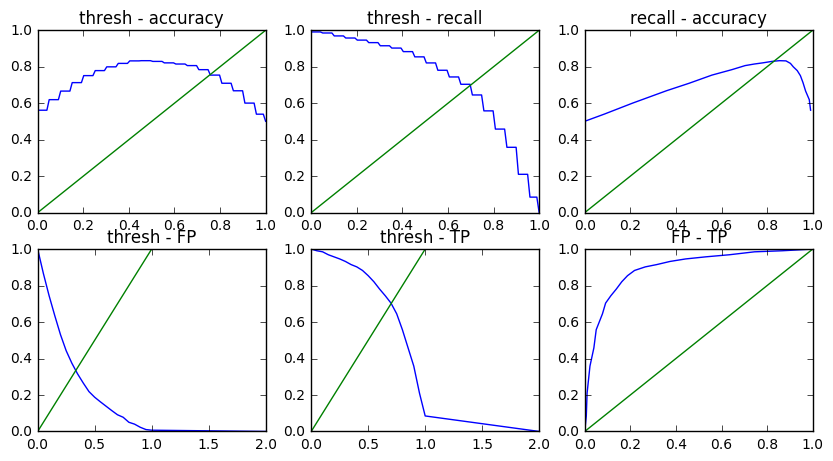

In [379]:
from sklearn.ensemble import RandomForestClassifier

def get_model():
    clf = RandomForestClassifier(n_estimators=20, 
                                 criterion='gini', 
                                 max_depth=None, 
                                 min_samples_split=2,
                                 min_samples_leaf=1, 
                                 min_weight_fraction_leaf=0.0, 
                                 max_features='auto', 
                                 max_leaf_nodes=None, 
                                 min_impurity_split=1e-07, bootstrap=True, oob_score=False, 
                                 n_jobs=1, random_state=None, verbose=0, warm_start=False, 
                                 class_weight=None)

    clf.fit(X_train, y_train)
    return clf

clf = run('rf.%s.%s.model' % (loc_type, version), get_model, True)
proba = clf.predict_proba(X_test)[:,1]

judge(clf, proba, target_acc=target_acc["rf_%s" % loc_type])

auc: 0.866212854054
acc on training data: 0.805101748352
acc on test data: 0.799426934097
best thresh: 0.292929292929 acc:recall 0.78452722063 0.905855338691 target acc: 0.78


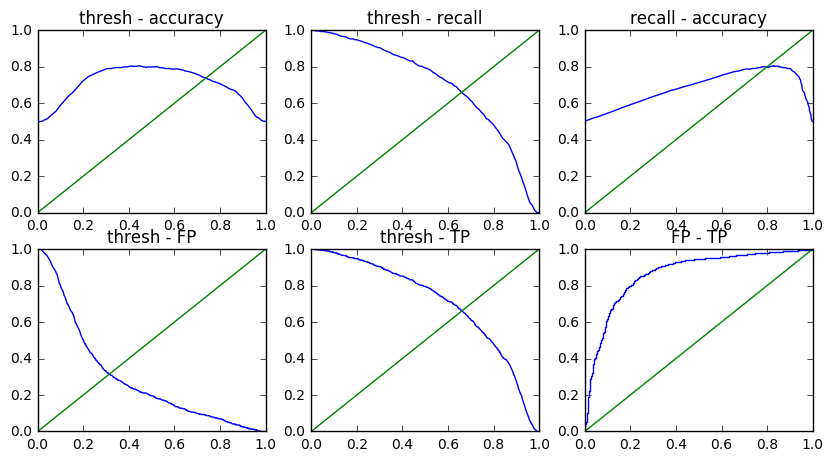

auc: 0.863991519256
acc on training data: 0.812983662941
acc on test data: 0.800573065903
best thresh: 0.40404040404 acc:recall 0.801146131805 0.849598163031 target acc: 0.8


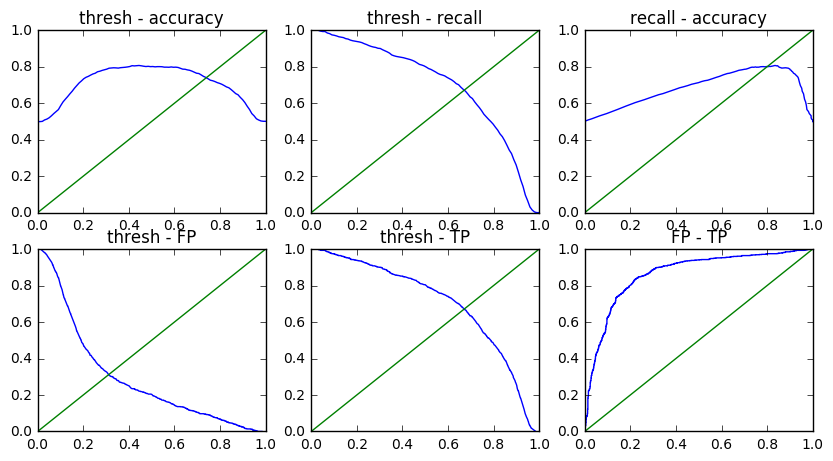

done


In [382]:
from sklearn import linear_model
from sklearn import svm
from sklearn.svm import LinearSVC

clf = linear_model.LogisticRegressionCV()
clf.fit(X_train, y_train)
proba = clf.predict_proba(X_test)[:,1]
judge(clf, proba, target_acc=0.78)


clf = svm.SVC(kernel='rbf', C=76, probability=True)
clf.fit(X_train, y_train)
proba = clf.predict_proba(X_test)[:,1]
judge(clf, proba, target_acc=0.80)

print 'done'